# Geospatial Big Data Analytics

DSML NTUA MSc
Vasileios Depastas
AM: 03400131

## Question 1
Αφού επιλέξετε περιοχή μελέτης, αναζητήστε δεδομένα raster, vector και δεδομένα χρονοσειρών για την συγκεκριμένη περιοχή. Χρησιμοποιήστε τουλάχιστον 2 διαφορετικές πηγές, καθώς και την υπηρεσία WFS.
[ενδεικτικές βιβλιοθήκες Python]: rasterio (για τα δεδομένα raster, εικόνες, κοκ), geopandas (δεδομένα vector, σημεία, πολύγωνα, κοκ και WFS υπηρεσία μεταμόρφωσης), pandas (εισαγωγή flat αρχείων)
[ενδεικτικά βήματα]:
✓ Πραγματοποιήστε λήψη διαχρονικών δεδομένων Sentinel-2 που απεικονίζουν την ευρύτερη περιοχή της Καστοριάς (https://pithos.okeanos.grnet.gr/public/fBSNLJeNxerluMj2MVDqF). Παρατηρήστε το συνοδευτικό PDF της εικόνας και τις αντιστοιχίες καναλιών και ημερομηνιών.
✓ Δημιουργήστε ένα vector αρχείο (π.χ GeoJSON, ESRI Shapefile) μέσω QGIS ή και στο geojson.io (https://geojson.io/) με την περιοχή μελέτης (πολύγωνο) πάνω στα δεδομένα Sentinel-2 της Καστοριάς και πραγματοποιήστε εισαγωγή του στην Python.
✓ Κάντε λήψη χρονοσειράς μετεωρολογικών δεδομένων από το portal της NASA (https://power.larc.nasa.gov/data-access-viewer/) για ένα σημείο εντός της περιοχής μελέτης και εισάγετε τα δεδομένα στην Python.
✓ Αναζητήστε τη WFS υπηρεσία για το Corine Land Cover 2018 και εισάγετε τα δεδομένα σας.

## Question 2.1
- For Sentinel-2 images timeseries downloaded, visualize for a date of your choice the bands Red, Green and Blue separately. Also, you can visualize selected indexes such as NDVI, EVI etc.

Sentinel 2 data loading from the broader Katoria region in Greece (<a href="https://pithos.okeanos.grnet.gr/public/fBSNLJeNxerluMj2MVDqF">Link to download data</a>). According to the pdf accompanying the data, there are two `.tif` large files:
- `Kastoria.tif`: 24 raster images spanning from 25-01-2016 until 30-12-2016 (corresponding doy range: 25 - 365) with 10 bands per image. This results in a spectro-temporal cube of dimension 240 x 2017 x 2281.
- `Kast_RefData_26Classes.tif`: image with 26 class codes for different land usages classification.

In [18]:
# imports
import os
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
import numpy as np
import fiona
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask as msk

In [2]:
# constants
KASTORIA_DATA_PATH = '/Kastoria_dataset/Kastoria.tif/'

In [3]:
full_kastoria_tiff_path = os.getcwd() + KASTORIA_DATA_PATH # combine current working directory with KASTORIA_DATA_PATH

# open Kastoria.tif dataset of 240 images (24 images with 10 bands each = 240)
with rasterio.open(fp=full_kastoria_tiff_path, mode='r') as kastoria_tif:
    print(f'The Kastoria dataset: {kastoria_tif}')
    print(f'Dataset shape: {kastoria_tif.read().shape}')

    bands_dtypes = set()
    nodatavalues = 0
    for i, dtype, nodataval in zip(kastoria_tif.indexes, kastoria_tif.dtypes, kastoria_tif.nodatavals):
        bands_dtypes.add(dtype) # add dtype element if not already in set
        if not nodataval: nodataval = 0
        nodatavalues += nodataval # sum of number of no data values
    print(f'The data types of the bands are: {bands_dtypes}')
    print(f'There are {nodatavalues} no data values in the dataset')

The Kastoria dataset: <open DatasetReader name='C:/Users/User/Downloads/DSML MsC/2nd semester/Γεωχωρικα/Geospatial_Lab Exercises/Lab02/Kastoria_dataset/Kastoria.tif' mode='r'>
Dataset shape: (240, 2017, 2281)
The data types of the bands are: {'float32'}
There are 0 no data values in the dataset


We will use matplotlib and rasterio to plot an image's specific color band next.

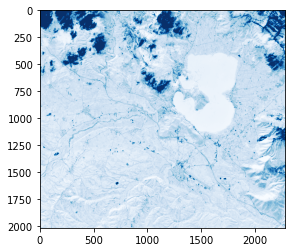

In [33]:
with rasterio.open(fp=full_kastoria_tiff_path, mode='r') as kastoria_tif: # open image dataset
    first_image_blue_band = kastoria_tif.read(1) # get the first/blue band of the first image of the dataset (first image has 10 bands spanning from indexes 1-10)
    plt.imshow(first_image_blue_band, cmap='Blues') # and use matplotlib to plot it
    plt.show()

However, using matplotlib we can see the pixel ranges in the two axis (horizontal and vertical) but we cannot label the axes with proper geo-referenced extents. This can be accomplished with rasterio.plot.show().

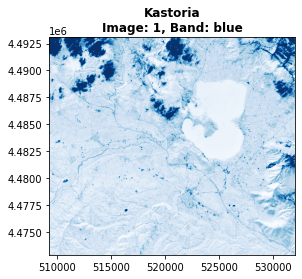

In [51]:
with rasterio.open(fp=full_kastoria_tiff_path, mode='r') as kastoria_tif: # open image dataset
    #The 1st image (first date of dataset) has indexes 1,2,...,10 for its 10 bands
    #The 1st band of it is the Blue band hence we will use 1 as the index for the image we plot below
    show(source=(kastoria_tif, 1), title='Kastoria\nImage: 1, Band: blue', cmap='Blues', with_bounds=True)

It's obvious that rasterio.plot.show() extends matplotlib's imshow() and can have geo-referenced axes.
Now we plot the three bands, R(Red), G(Green) and B(Blue).

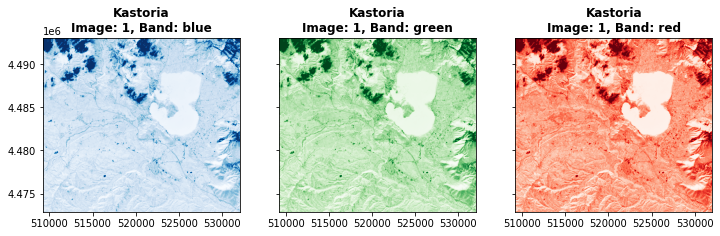

In [52]:
with rasterio.open(fp=full_kastoria_tiff_path, mode='r') as kastoria_tif: # open image dataset

    fig, (ax_blue, ax_green, ax_red) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,7))

    show(source=(kastoria_tif, 1), ax=ax_blue, title='Kastoria\nImage: 1, Band: blue', cmap='Blues', with_bounds=True)
    show(source=(kastoria_tif, 2), ax=ax_green, title='Kastoria\nImage: 1, Band: green', cmap='Greens', with_bounds=True)
    show(source=(kastoria_tif, 3), ax=ax_red, title='Kastoria\nImage: 1, Band: red', cmap='Reds', with_bounds=True)

We also construct and plot the RGB raster image (1st image of Kastoria's tif dataset) from the three bands.

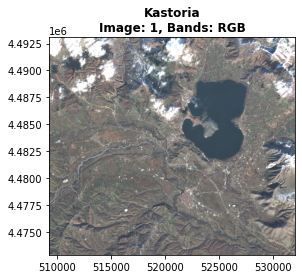

In [62]:
with rasterio.open(fp=full_kastoria_tiff_path, mode='r') as kastoria_tif: # open image dataset
    show(source=(kastoria_tif, (3,2,1)), title='Kastoria\nImage: 1, Bands: RGB', with_bounds=True)

We will now calculate the NDVI index for that first image and show it on a map layer:

In [61]:
np.subtract(10, 1)

9

In [64]:
def calculate_ndvi_band(red_band, nir_band) -> np.array:
    # NDVI = (NIR – Red) / (NIR + Red)
    #return (nir_band-red_band)/(nir_band+red_band)

    ndvi = np.divide(np.subtract(nir_band, red_band), np.add(nir_band, red_band))
    # if the ndvi denominator nir+red happens to be 0 (when nir=red=0) then the numpy assigns value np.inf, and here we replace this with 0
    ndvi = np.where(ndvi == np.inf, -1, ndvi)
    return ndvi


Max NDVI: 0.5877651572227478
Mean NDVI: -0.0372689850628376
Median NDVI: 0.0
Min NDVI: -0.6840791702270508


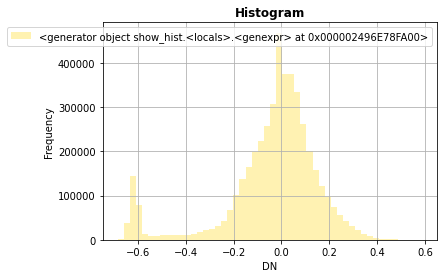

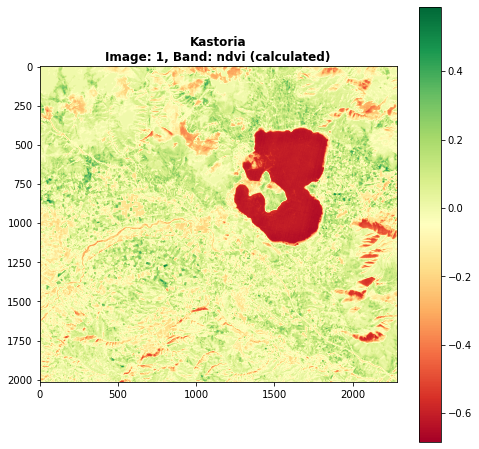

In [101]:
with rasterio.open(fp=full_kastoria_tiff_path, mode='r') as kastoria_tif: # open image dataset
    # calculate red, nir bands and derive from there the ndvi band for the first image of the dataset
    first_image_red_band = kastoria_tif.read(3) # NIR (near infrared)
    first_image_nir_band = kastoria_tif.read(4) # RED band
    first_image_ndvi_band = calculate_ndvi_band(red_band=first_image_red_band, nir_band=first_image_nir_band) # NDVI band
    # plot kastoria area's ndvi band map layer using RedYellowGreen colormap
    #show(source=first_image_ndvi_band, title='Kastoria\nImage: 1, Band: ndvi (calculated)', cmap='RdYlGn', with_bounds=True)

    # print some info on ndvi band
    print('\nMax NDVI: {m}'.format(m=first_image_ndvi_band.max()))
    print('Mean NDVI: {m}'.format(m=first_image_ndvi_band.mean()))
    print('Median NDVI: {m}'.format(m=np.median(first_image_ndvi_band)))
    print('Min NDVI: {m}'.format(m=first_image_ndvi_band.min()))

    # histogram of ndvi pixel values
    rasterio.plot.show_hist(first_image_ndvi_band, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3)

    # figure with ndvi band and colormap on the side (vertical)
    fig, ax = plt.subplots(figsize=(8, 8))
    # use imshow so that we have something to map the colorbar to
    image_hidden = ax.imshow(first_image_ndvi_band, cmap='RdYlGn')
    # plot on the same axis with rio.plot.show
    show(source=first_image_ndvi_band, ax=ax, title='Kastoria\nImage: 1, Band: ndvi (calculated)', cmap='RdYlGn', with_bounds=True)
    # add colorbar using the now hidden image
    fig.colorbar(image_hidden, ax=ax)

In general, NDVI values range from -1.0 to 1.0, with negative values indicating clouds and water, positive values near zero indicating bare soil, and higher positive values of NDVI ranging from sparse vegetation (0.1 - 0.5) to dense green vegetation (0.6 and above).


## Question 2.2
- Select a region of interest (ROI) within the Kastoria area as given in the dataset and clip (crop) the selected ROI based on the vector file describing it.

A shape files stores both the geometric location and attribute information of geographic features like lines, points or polygons. Clipping an image is also called masking (of a raster file by a shape file). In our case, we use <a href="geojson.io">geojson.io</a> to draw a polygon region of interest (ROI) in Kastoria and download the shapefile related to that in order to clip it afterwards from the images of the dataset and concentrate subsequent steps on that ROI solely.

In [4]:
KASTORIA_POLYGON_SHAPEFILE = os.getcwd() + '/Shapefiles/Kastoria ROI/POLYGON.shp' # path to Kastoria polygon shapefile
KASTORIA_DATA_PATH_WITH_NEW_CRS = '/Kastoria_dataset/Kastoria_new_crs.tif/'
KASTORIA_DATA_PATH_WITH_NEW_CRS_CLIPPED = '/Kastoria_dataset/Kastoria_new_crs_clipped.tif/'

In [5]:
# Read shape file using geopandas
shape_file = gpd.read_file(filename=KASTORIA_POLYGON_SHAPEFILE)


# Check coordinate reference system (CRS) of both raster image(s) and shapefile
print('Shape file crs: ', shape_file.crs)
print('-----------------------------------------------------')
with rasterio.open(fp=full_kastoria_tiff_path, mode='r') as kastoria_tif: # open image dataset
    print('Kastoria raster images dataset file crs: ', kastoria_tif.crs)


Shape file crs:  epsg:4326
-----------------------------------------------------
Kastoria raster images dataset file crs:  EPSG:32634


We can see that the coordinate reference system for the Kastoria raster images dataset and the shapefile are different. Therefore, we will have to transform the projection of the dataset to match that of the shape file.

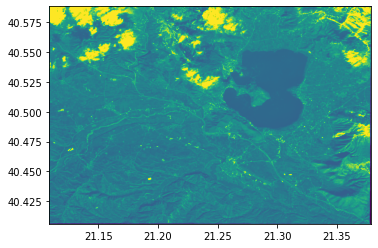

Transformed Imagery file Projection:  EPSG:4326
CPU times: total: 15min 21s
Wall time: 54min 19s


In [141]:
%%time

# Transform dataset crs to match that of shape file
target_crs = shape_file.crs # target crs (coordinate reference system)

# Save output dataset file after crs transformation
full_kastoria_new_crs_tiff_path = os.getcwd() + KASTORIA_DATA_PATH_WITH_NEW_CRS

with rasterio.open(fp=full_kastoria_tiff_path, mode='r') as kastoria_tif: # open image dataset
    transform, width, height = calculate_default_transform(kastoria_tif.crs, target_crs, kastoria_tif.width, kastoria_tif.height, *kastoria_tif.bounds)
    kwargs = kastoria_tif.meta.copy()
    kwargs.update({'crs': target_crs, 'transform': transform, 'width': width, 'height': height})
    with rasterio.open(fp=full_kastoria_new_crs_tiff_path, mode='w', **kwargs) as dst: # open image dataset that we will write the new transformed crs dataset
        for i in range(1, kastoria_tif.count + 1):
            reproject(
                source=rasterio.band(kastoria_tif, i),
                destination=rasterio.band(dst, i),
                src_transform=kastoria_tif.transform,
                src_crs=kastoria_tif.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest,
                num_threads=8)


# Plot again after transformation. You can observe axis value have changed
tr_imagery = rasterio.open(full_kastoria_new_crs_tiff_path)
# Plot trasformed imagery
show(tr_imagery)

# Check coordinate reference system of transformed imagery, it's changed or not?
print('Transformed Imagery file Projection: ', tr_imagery.crs)
# tr_imagery.crs

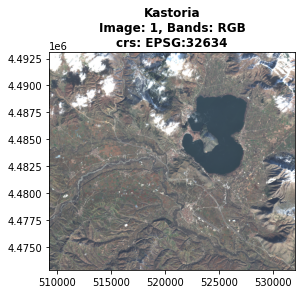

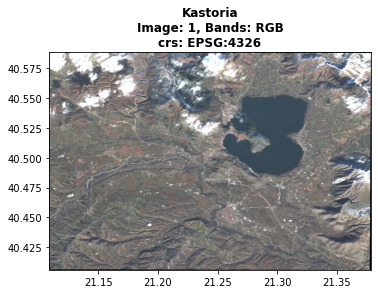

In [143]:
with rasterio.open(fp=full_kastoria_tiff_path, mode='r') as kastoria_tif: # open image dataset
    show(source=(kastoria_tif, (3,2,1)), title=f'Kastoria\nImage: 1, Bands: RGB\ncrs: {kastoria_tif.crs}', with_bounds=True)

with rasterio.open(fp=full_kastoria_new_crs_tiff_path, mode='r') as kastoria_tif: # open modified crs image dataset
    show(source=(kastoria_tif, (3,2,1)), title=f'Kastoria\nImage: 1, Bands: RGB\ncrs: {kastoria_tif.crs}', with_bounds=True)

Now that the initial EPSG 32634 dataset is transformed to EPSG 4326, we can clip the ROI from it.

In [20]:
# Clipping the image

# Read shapefile
with fiona.open(KASTORIA_POLYGON_SHAPEFILE, mode='r') as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# Read raster images transformed crs dataset file
with rasterio.open(fp=full_kastoria_new_crs_tiff_path, mode='r') as kastoria_tif_transformed: # open modified crs image dataset
    out_image, out_transform = msk(kastoria_tif_transformed, shapes, crop=True)
    out_meta = kastoria_tif_transformed.meta

# Save clipped images dataset
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Save output dataset file after clipping of all the iamges and bands
full_kastoria_new_crs_clipped_tiff_path = os.getcwd() + KASTORIA_DATA_PATH_WITH_NEW_CRS_CLIPPED
with rasterio.open(fp=full_kastoria_new_crs_clipped_tiff_path, mode="w", **out_meta) as dest:
    dest.write(out_image)

In [25]:
with rasterio.open(fp=full_kastoria_new_crs_clipped_tiff_path, mode="r") as clipped_dataset:
    print('Clipped dataset information:')
    print(f'CRS: {clipped_dataset.crs}')
    print(f'# Images: {clipped_dataset.count}')
    print(f'Images (width, height) = {clipped_dataset.width, clipped_dataset.height}')

Clipped dataset information:
CRS: EPSG:4326
# Images: 240
Images (width, height) = (534, 389)


We can plot the original RGB image of the original Kastoria area of the initial dataset along with the mask (ROI) that we clipped in order to visualize the region that we keep for subsequent analysis in next steps.

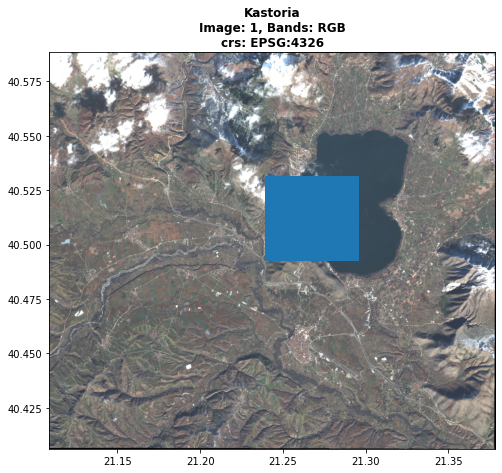

In [41]:
with rasterio.open(fp=full_kastoria_new_crs_tiff_path, mode='r') as kastoria_tif: # open modified crs image dataset
    fig, ax = plt.subplots(figsize=(8,8))

    show(source=(kastoria_tif, (3,2,1)), ax=ax, title=f'Kastoria\nImage: 1, Bands: RGB\ncrs: {kastoria_tif.crs}', with_bounds=True)
    shape_file.plot(ax=ax)

We can see that the clipped area selected (ROI) is a rectangular that contains both water and land in order to spot the differences in different types of land usage in subsequent analysis.

Next, we plot the first image (first date) of the clipped dataset in RGB.

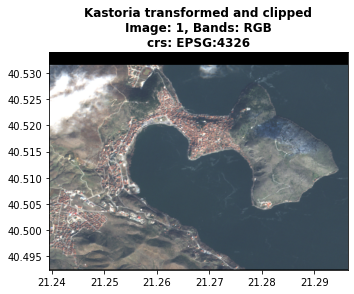

In [44]:
with rasterio.open(fp=full_kastoria_new_crs_clipped_tiff_path, mode='r') as kastoria_tif_transformed_clipped: # open modified crs and clipped image dataset
    show(source=(kastoria_tif_transformed_clipped, (3,2,1)), title=f'Kastoria transformed and clipped\nImage: 1, Bands: RGB\ncrs: {kastoria_tif_transformed_clipped.crs}', with_bounds=True)

## Question 2.3
- For each available date, visualize NDVI band and calculate the mean NDVI value in the ROI (clipped image)

C:\Users\User\AppData\Local\Temp\ipykernel_6212\2688722270.py:5: RuntimeWarning: invalid value encountered in true_divide
  ndvi = np.divide(np.subtract(nir_band, red_band), np.add(nir_band, red_band))


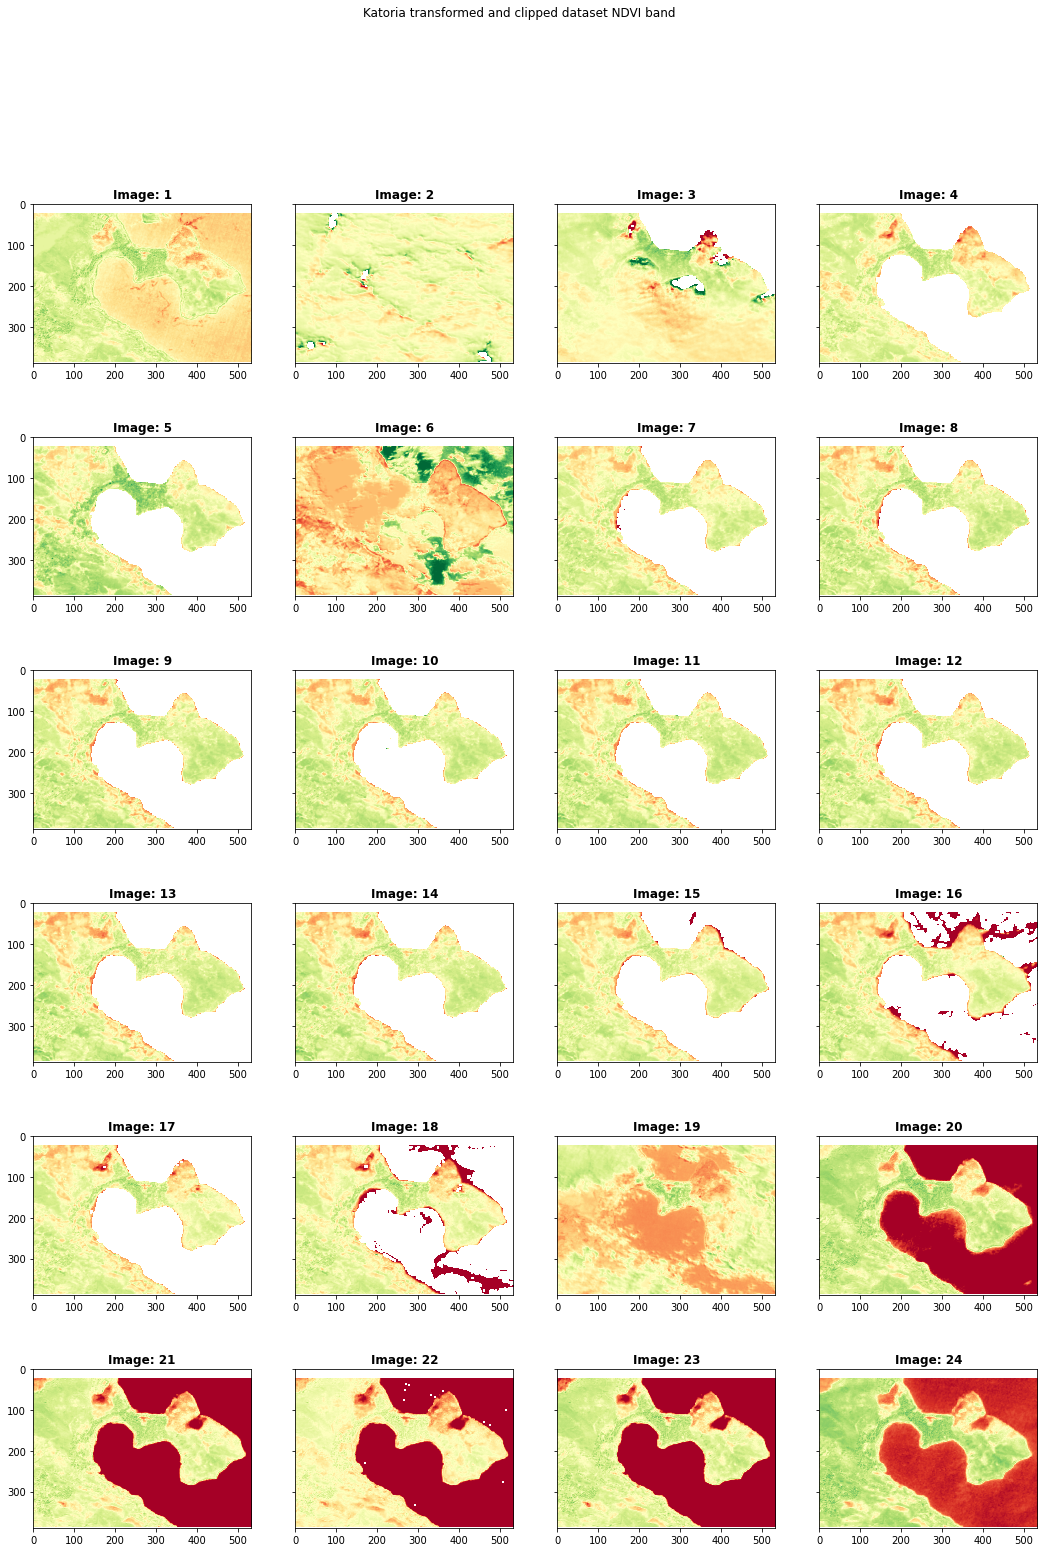

In [70]:
with rasterio.open(fp=full_kastoria_new_crs_clipped_tiff_path, mode='r') as kastoria_tif_transformed_clipped: # open modified crs and clipped image dataset
    fig, ax = plt.subplots(nrows=6, ncols=4, sharey=True, figsize = (18,25)) # prepare figure to plot 24 images for 24 distinct dates
    fig.suptitle('Katoria transformed and clipped dataset NDVI band')

    for i in range(1, kastoria_tif_transformed_clipped.count + 1, 10): #1 to 240 (included) with step 10 to get all the images's red and nir bands
        red_band_index, nir_band_index = i+3, i+4 #eg for first image the indexes are (3,4), for second image (13,14) etc.

        # calculate the ndvi band for each image of the transformed & clipped dataset
        red_band = kastoria_tif_transformed_clipped.read(red_band_index) # RED band
        nir_band = kastoria_tif_transformed_clipped.read(nir_band_index) # NIR band
        ndvi_band = calculate_ndvi_band(red_band=red_band, nir_band=nir_band) # NDVI band calculation

        # calculate image's count
        image_index = i // 10 + 1
        # plot figure grid for 6 rows and 4 columns starts from [0, 0] and goes all the way to [5, 3]
        plot_row_index = (image_index - 1) // 4
        plot_col_index = (image_index - 1) % 4

        # plot on the appropriate position of the figure's grid based on ax[] row and column indexes
        show(source=ndvi_band, ax=ax[plot_r6ow_index, plot_col_index], title=f'Image: {image_index}', cmap='RdYlGn', with_bounds=True)

    # add colorbar
    #fig.colorbar(image_hidden, ax=ax)

Next, we calculate the mean NDVI value of each pixel over the time series of the 24 dates (i.e. 24 ROI images) and plot it.

C:\Users\User\AppData\Local\Temp\ipykernel_6212\2688722270.py:5: RuntimeWarning: invalid value encountered in true_divide
  ndvi = np.divide(np.subtract(nir_band, red_band), np.add(nir_band, red_band))


Min NDVI value for the image with mean pixel ndvi values: -0.6353932023048401
Max NDVI value for the image with mean pixel ndvi values: 0.6414283514022827


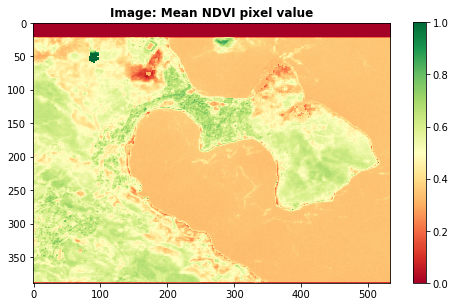

In [113]:
with rasterio.open(fp=full_kastoria_new_crs_clipped_tiff_path, mode="r") as clipped_dataset: # open the crs transfrmed and clipped dataset
    first_image_first_band = clipped_dataset.read(1) # select any band (here for simplicity the 1st) of the first image available in the dataset
    ndvi_sum_array = np.zeros_like(first_image_first_band) # array with zeros of proper size that will hold the sum of ndvi values over the 24 images (taking in 24 different dates)

with rasterio.open(fp=full_kastoria_new_crs_clipped_tiff_path, mode='r') as kastoria_tif_transformed_clipped: # open modified crs and clipped image dataset
    for i in range(1, kastoria_tif_transformed_clipped.count + 1, 10): #1 to 240 (included) with step 10 to get all the images's red and nir bands
        red_band_index, nir_band_index = i+3, i+4 #eg for first image the indexes are (3,4), for second image (13,14) etc.

        # calculate the ndvi band for each image of the transformed & clipped dataset
        red_band = kastoria_tif_transformed_clipped.read(red_band_index) # RED band
        nir_band = kastoria_tif_transformed_clipped.read(nir_band_index) # NIR band
        ndvi_band = calculate_ndvi_band(red_band=red_band, nir_band=nir_band) # NDVI band calculation

        # update nvdvi sum array by just adding element/pixel wise the values of each image one after another
        ndvi_sum_array = np.add(ndvi_sum_array, ndvi_band)

    # having added the ndvi values of each pixel for the 24 dates, we now have to divide with 24 to get the mean
    ndvi_mean_array = np.divide(ndvi_sum_array, 24)

    # display mean ndvi pixel value in a single image
    fig, ax = plt.subplots(figsize=(8, 8)) # figure with ndvi band and colormap on the side (vertical)
    # use imshow so that we have something to map the colorbar to
    image_hidden = ax.imshow(kastoria_tif_transformed_clipped.read(1), cmap='RdYlGn')
    # plot on the same axis with rio.plot.show
    show(source=ndvi_mean_array, ax=ax, title=f'Image: Mean NDVI pixel value', cmap='RdYlGn', with_bounds=True)
    # add colorbar using the now hidden image
    fig.colorbar(image_hidden, ax=ax, shrink=0.6)

print(f'Min NDVI value for the image with mean pixel ndvi values: {np.nanmin(ndvi_mean_array)}')
print(f'Max NDVI value for the image with mean pixel ndvi values: {np.nanmax(ndvi_mean_array)}')

## Question 2.4
- Present a graph with the progress of the NDVI index in time for the ROI
For this task we will calculate the mean value of all pixels of the NDVI band for each image/date and then plot the resulting time series.

In [126]:
mean_image_ndvi_series = []

with rasterio.open(fp=full_kastoria_new_crs_clipped_tiff_path, mode='r') as kastoria_tif_transformed_clipped: # open modified crs and clipped image dataset
    for i in range(1, kastoria_tif_transformed_clipped.count + 1, 10): #1 to 240 (included) with step 10 to get all the images's red and nir bands
        red_band_index, nir_band_index = i+3, i+4 #eg for first image the indexes are (3,4), for second image (13,14) etc.

        # calculate the ndvi band for each image of the transformed & clipped dataset
        red_band = kastoria_tif_transformed_clipped.read(red_band_index) # RED band
        nir_band = kastoria_tif_transformed_clipped.read(nir_band_index) # NIR band
        ndvi_band = calculate_ndvi_band(red_band=red_band, nir_band=nir_band) # NDVI band calculation

        # calculate mean ndvi image ignoring nans
        mean_image_ndvi = np.nanmean(ndvi_band)

        # append the list of mean ndvi image values
        mean_image_ndvi_series.append(mean_image_ndvi)

dates = ['2016-01-25', '2016-02-14', '2016-03-28', '2016-04-04', '2016-04-27', '2016-06-06', '2016-07-03', '2016-07-13', '2016-07-23', '2016-07-26', '2016-08-05','2016-08-12', '2016-08-15',
             '2016-08-22', '2016-09-04', '2016-09-14', '2016-10-01', '2016-10-14', '2016-11-13', '2016-12-03', '2016-12-10', '2016-12-20', '2016-12-23', '2016-12-30']
doy = [25, 45, 88, 95, 118, 158, 185, 195, 205, 208, 218, 225, 228, 235, 248, 258, 275,
       288, 318, 338, 345, 355, 358, 365]

C:\Users\User\AppData\Local\Temp\ipykernel_6212\2688722270.py:5: RuntimeWarning: invalid value encountered in true_divide
  ndvi = np.divide(np.subtract(nir_band, red_band), np.add(nir_band, red_band))


In [127]:
print('DOY, date pairs in dataset:')
for day_doy, date in zip(doy, dates):
    print(f'{day_doy, date}')

DOY, date pairs in dataset:
(25, '2016-01-25')
(45, '2016-02-14')
(88, '2016-03-28')
(95, '2016-04-04')
(118, '2016-04-27')
(158, '2016-06-06')
(185, '2016-07-03')
(195, '2016-07-13')
(205, '2016-07-23')
(208, '2016-07-26')
(218, '2016-08-05')
(225, '2016-08-12')
(228, '2016-08-15')
(235, '2016-08-22')
(248, '2016-09-04')
(258, '2016-09-14')
(275, '2016-10-01')
(288, '2016-10-14')
(318, '2016-11-13')
(338, '2016-12-03')
(345, '2016-12-10')
(355, '2016-12-20')
(358, '2016-12-23')
(365, '2016-12-30')


Text(0, 0.5, 'NDVI mean ROI')

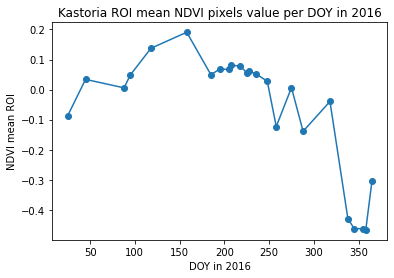

In [128]:
plt.plot(doy, mean_image_ndvi_series)
plt.scatter(doy, mean_image_ndvi_series)
plt.title('Kastoria ROI mean NDVI pixels value per DOY in 2016')
plt.xlabel('DOY in 2016')
plt.ylabel('NDVI mean ROI')

We observe that the highest mean NDVI pixels value is found on the 158th day of 2016 (2016-06-06), right in the summer which is somewhat expected. On the cotrary we observe lower values for winter months towards the end of year 2016 and at the beginning of it. Also, given that the ROI selected contains a large pater of water area, the NDVI mean values are fluctuating around 0, whereas if the area was mostly land, we might have expected higher mean ndvi values.

TESTING DATASET

In [102]:
kastoria_tif = rasterio.open(fp=full_kastoria_tiff_path, mode='r') # open image dataset

# code here


In [103]:
# close the dataset
kastoria_tif.close()

## Question 3
Υλοποιήστε και εξασκηθείτε με διάφορα χωρικά ερωτήματα και πράξεις με την βοήθεια της βιβλιοθήκης Geopandas στα vector δεδομένα σας. Δημιουργήστε στατικούς χάρτες με αυτά. Παρουσιάστε γραφήματα της χρονοσειράς δεδομένων.
[ενδεικτικές βιβλιοθήκες Python]: geopandas, pandas, matplotlib
[ενδεικτικά βήματα ερωτήματος]:
✓ Κατεβάστε vector δεδομένα από το https://geodata.gov.gr/, όπως διοικητικά όρια νομών, σιδηροδρομικό δίκτυο, τοποθεσίες νοσοκομείων κλπ.
✓ Χρησιμοποιήστε την βιβλιοθήκη geopandas για υλοποίηση χωρικών ερωτημάτων (όπως within, intersect, buffer, spatial join)
✓ Πραγματοποιήστε εξαγωγή από τη WFS υπηρεσία για το Corine Land Cover 2018 και τα δεδομένα που αφορούν την περιοχή μελέτης κλπ.
✓ Στατικοί χάρτες 1) Corine Land Cover στη περιοχή μελέτης, 2) του πολυγώνου της περιοχής μελέτης καθώς και 3) του σημείου των μετεωρολογικών δεδομένων κλπ.
✓ Γραφήματα με την εξέλιξη μετεωρολογικών μεταβλητών (πχ θερμοκρασία, υγρασία, κα) στον χρόνο.

In [ ]:
#import pandas, matplotlib, geopandas